# fit_baseline_CNN

Fitting convolutional neural network as [D-S 2018](https://ui.adsabs.harvard.edu/abs/2018MNRAS.476.3661D/abstract) (with similar architecture - although different image size and slightly different normalisation) to evaluate baseline performance for regression (galaxy spin).

---
- Hyperparameter tuning will be implemented _if_ model training doesn't take a very long time.

In [1]:
import keras 
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn import model_selection
import sdss_model_constructors
from scipy import stats

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

### Loading in pre-processed data
- SDSS image data downscaled to (80, 80) in shape and normalised to RGB values (0-1).
- Using sklearn to split into training, validation and test datasets.

In [2]:
data_dir = '../../data/cleaned_datasets/'

x = np.load(data_dir + 'x.npy')
y = np.load(data_dir + 'y.npy')

In [3]:
train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

# creating training sample
X_train, X_test, y_train, y_test = model_selection.train_test_split(x, y, test_size = 1 - train_ratio)

# creating test and validation training samples.
X_val, X_test, y_val, y_test = model_selection.train_test_split(X_test, y_test, test_size = test_ratio / (test_ratio + validation_ratio)) 
y_train.shape, y_val.shape, y_test.shape

((4505,), (966,), (966,))

### Using data generator objects to automatically augment training images to increase sample size.

In [4]:
train_gen = ImageDataGenerator(rotation_range = 45,  # randomly rotate images in the range (degrees, 0 to 45)
                               zoom_range = 0.25, # zoom range between 0.75 and 1.25 original size
                               horizontal_flip = True,
                               vertical_flip = True,
                               width_shift_range=0.05, # shifting centre by up-to 5%
                               height_shift_range=0.05) # shifting centre by up-to 5%

train_gen.fit(X_train)

### Loading baseline CNN and returning summary.

In [5]:
model = sdss_model_constructors.build_baseline_CNN((80, 80, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 75, 75, 32)        3488      
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 71, 71, 64)        51264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 35, 35, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       32896     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 17, 128)       0

### Fitting CNN for 25 epochs
- Quickly identify if model is converging or not.

In [6]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001, verbose=1)

model.fit(train_gen.flow(X_train, y_train, batch_size=32),
          validation_data=(X_val, y_val), callbacks=[reduce_lr,],
          epochs=25)

Epoch 1/25
141/141 [==============================] - 53s 375ms/step - loss: 0.1531 - val_loss: 0.0477
Epoch 2/25
141/141 [==============================] - 53s 378ms/step - loss: 0.0331 - val_loss: 0.0379
Epoch 3/25
141/141 [==============================] - 56s 397ms/step - loss: 0.0313 - val_loss: 0.0371
Epoch 4/25
141/141 [==============================] - 57s 404ms/step - loss: 0.0286 - val_loss: 0.0478
Epoch 5/25
141/141 [==============================] - 58s 408ms/step - loss: 0.0283 - val_loss: 0.0398
Epoch 6/25
141/141 [==============================] - 57s 405ms/step - loss: 0.0280 - val_loss: 0.0392
Epoch 7/25
141/141 [==============================] - 58s 408ms/step - loss: 0.0273 - val_loss: 0.0274
Epoch 8/25
141/141 [==============================] - 58s 414ms/step - loss: 0.0266 - val_loss: 0.0274
Epoch 9/25
141/141 [==============================] - 58s 410ms/step - loss: 0.0274 - val_loss: 0.0283
Epoch 10/25
141/141 [==============================] - 59s 417ms/step - l

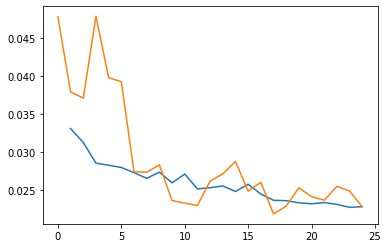

In [7]:
pd.DataFrame(model.history.history)['loss'][1:].plot()
pd.DataFrame(model.history.history)['val_loss'].plot()
#plt.yscale('log')

### Using test data to evaluate performance of predictions

In [8]:
test_loss = model.evaluate(X_test, y_test)
y_predicted = model.predict(X_test).ravel()

31/31 [==============================] - 2s 77ms/step - loss: 0.0247


0.3791856 0.42522943870496893


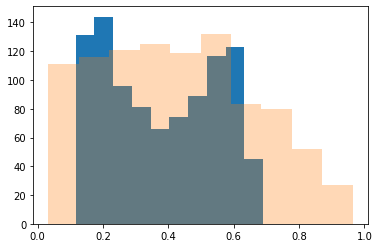

In [9]:
plt.hist(y_predicted)
plt.hist(y_test, alpha=0.3)

print(np.mean(y_predicted), np.mean(y_test))

/opt/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


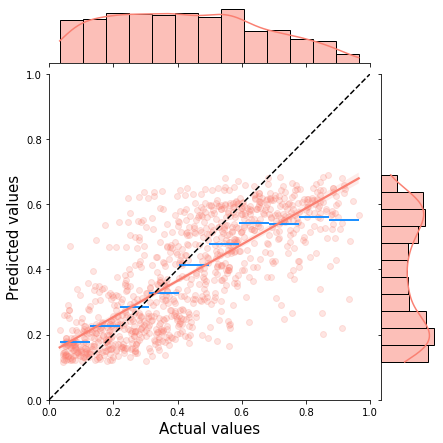

In [26]:
g = sns.jointplot(y_test, y_predicted, kind="reg", xlim=(-0.05, 1), ylim=(-0.05, 1), color='salmon',
                  joint_kws = {'scatter_kws': dict(alpha=0.2)})
x = np.linspace(0, 1, 20)
plt.plot(x, x, linestyle='dashed', color='k')
plt.xlabel('Actual values', fontsize=15)
plt.ylabel('Predicted values', fontsize=15)
plt.xlim([0,1])
plt.ylim([0,1])
stats.binned_statistic(y_test, y_predicted, statistic='mean')[1]
bin_means, bin_edges, binnumber = stats.binned_statistic(y_test, y_predicted, statistic='mean')
bin_std, _, _ = stats.binned_statistic(y_test, y_predicted, statistic='std')
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='dodgerblue', lw=2)


In [11]:
stats.pearsonr(y_test, y_predicted)

(0.7648435959280668, 2.705703649395973e-186)

## Summary
- Baseline appears sensible to prediction
- Mapping photometry to galaxy spin contains siginificant scatter, so an even mildly informative prediction is probably a success
- Regression problem can naturally lead to difficulty in predicting full range of output data (considering loss is based on MSE)
- Performance is similar to T-type (also regression output using SDSS photometry) predictions in DS+18
- Next steps is to tune the number of nodes in the layers (already have chosen highest converging LR) and potentially dropout